# Desafio 5
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

Review Text  Rating
0  Absolutely wonderful - silky and sexy and comf...       3
1  Love this dress!  it's sooo pretty.  i happene...       4
2  I had such high hopes for this dress and reall...       2
3  I love, love, love this jumpsuit. it's fun, fl...       4
4  This shirt is very flattering to all due to th...       4

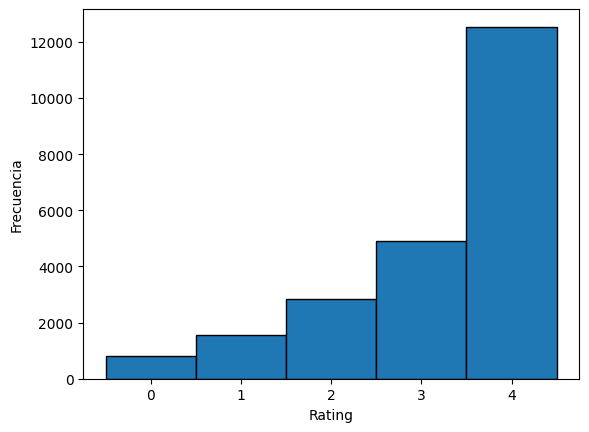

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

import matplotlib.pyplot as plt

plt.hist(df_reviews['Rating'],bins=[0,1,2,3,4, 5], align='left', edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


Para mejorar este dataset desbalanceado se propone:

1. combinar las clases 0, 1 y 2, y renumerar el rating.
2. aplicar submuestreo en las que así lo requieran a fin de obtener el dataset balanceado.


In [7]:
# combinar clases 0, 1, 2. Renumerar el rating para que sea entre 0 y 2.

df_reviews_b = df_reviews
df_reviews_b.loc[df_reviews['Rating'] == 1, 'Rating'] = 0 # clase 0 donde dice 1
df_reviews_b.loc[df_reviews['Rating'] == 2, 'Rating'] = 0 # clase 1 donde dice 2
df_reviews_b.loc[df_reviews['Rating'] == 3, 'Rating'] = 1 # clase 2 donde dice 3
df_reviews_b.loc[df_reviews['Rating'] == 4, 'Rating'] = 2 # clase 3 donde dice 4


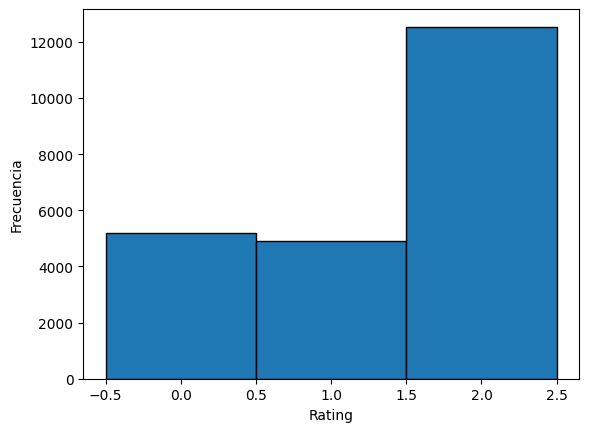

In [8]:
# grafico el histograma del nuevo dataset algo más balanceado que el orginal

plt.hist(df_reviews_b['Rating'],bins=[0,1,2,3], align='left', edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
df_reviews_b.groupby(['Rating']).count()

Review Text
Rating             
0              5193
1              4908
2             12540

In [10]:
# submuestreo a la clase 2 para llevarla a 5193 registros

from sklearn.utils import resample

clase_mayoritaria = df_reviews_b[df_reviews_b['Rating'] == 2]
clase_minoritaria = df_reviews_b[df_reviews_b['Rating'] == 0]
resto = df_reviews_b[df_reviews_b['Rating'] == 1]

clase_mayoritaria_submuestreada = resample(clase_mayoritaria, replace=False, n_samples=len(clase_minoritaria), random_state=46)
df_reviews_b = pd.concat([resto, clase_mayoritaria_submuestreada, clase_minoritaria])


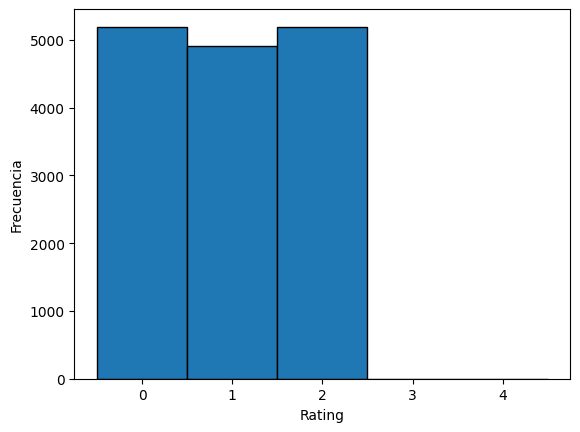

In [11]:
# grafico el histograma del nuevo dataset algo más balanceado que el orginal

plt.hist(df_reviews_b['Rating'],bins=[0,1,2,3,4,5], align='left', edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

De esta forma las clases quedaron bastante balanceadas entre sí.


In [12]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

import numpy as np

reviews = df_reviews_b['Rating'].to_numpy()

print(reviews)


[1 1 1 ... 0 0 0]


In [13]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

print(reviews.size)

15294


In [14]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = df_reviews_b.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Absolutely wonderful - silky and sexy and comfortable I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn\'t go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size... I took these out of the package and wanted them to fit so badly, but i could tell before i put them on that they wouldn\'t. these are for an hour-glass figure. i am more straight up and down. the waist was way too small for my body shape and even if i sized up, i could tell they would still be tight in the waist and too roomy in the hips - for me. that said, they are really nice. sturdy, linen-like fabric, pretty color, well made. i hope they make someone v

In [15]:
# Alumno: ¿Cuál es la longitud de ese corpus?

print("longitud de ese corpus:", len(corpus))

longitud de ese corpus: 4812459


In [16]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens=text_to_word_sequence(corpus)

In [17]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'i',
 'ordered',
 'this',
 'in',
 'carbon',
 'for',
 'store',
 'pick',
 'up',
 'and',
 'had',
 'a',
 'ton']

In [18]:
# Alumno: ¿Cuántos tokens/palabras hay?
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 943646


In [19]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.

from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

text_sequences = df_reviews_b['Review Text'].values

tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(text_sequences)

In [20]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tok.word_index
print(f'Tamaño del vocavulario: {len(word_index)}')

Tamaño del vocavulario: 12646


In [21]:
# Alumno: Convertir las palabras/tokens a
sequences = tok.texts_to_sequences(text_sequences)

In [22]:
# Alumno: Determinar cual es la oración más larga

i = max(range(len(sequences)), key=lambda i: len(sequences[i]))

print('Tamaño de la oración más larga:',len(sequences[i]))

for j in range(len(sequences[i])):
  print(tok.index_word[sequences[i][j]]+' ', end='')

Tamaño de la oración más larga: 115
i love maeve tops i love the material and feel of this brand when i saw the new tops that came out i ran to my local store to try one on i'm usually a large in a top once in a while an xl they only had a large to try so i tried it in the black motif i could barely get the top on it looked like i was missing 1 2 of the top i checked the size and it was a large it's a shame the top is really cute if you are the least bit broad or busty go up a size or two if you are usually a 

In [23]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

X = pad_sequences(sequences, maxlen=maxlen, padding='pre')
X

array([[   0,    0,    0, ...,  772,    3,   85],
       [   0,    0,    0, ..., 1351, 1660,   21],
       [   0,    0,    0, ...,  377,   23,  321],
       ...,
       [   0,    0,    0, ...,  506,   36,  570],
       [   0,    0,    0, ...,   22,  159,   39],
       [   0,    0,    0, ...,  117,  188,  186]], dtype=int32)

In [24]:
# Alumno: Observar las dimensiones de la variable input
X.shape


(15294, 115)

In [25]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = df_reviews_b['Rating'].values
print(y.shape)

(15294,)


In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

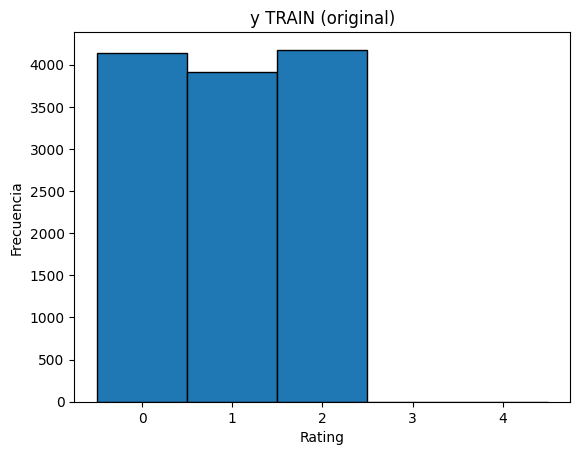

In [27]:
# grafico el histograma del y train orginal

plt.hist(y_train, bins=[0,1,2,3,4,5], align='left', edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('y TRAIN (original)')
plt.show()

In [28]:
# one hot encoding de y (train y test) ...

y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

print(y_train_encoded)

       0  1  2
0      0  0  1
1      0  1  0
2      0  1  0
3      0  1  0
4      1  0  0
...   .. .. ..
12230  0  1  0
12231  0  1  0
12232  0  0  1
12233  1  0  0
12234  0  0  1

[12235 rows x 3 columns]


In [36]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1]
out_shape = 3
print('in_shape', in_shape, 'out_shape', out_shape)

in_shape 115 out_shape 3


# ENTRENAMIENTO MODELO 1

In [37]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout, Dense, Bidirectional, GRU

In [41]:
#!pip install tensorflow_addons
import tensorflow_addons as tfa

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',  tfa.metrics.F1Score(num_classes=3,average=None)])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 115, 50)           100050    
                                                                 
 bidirectional_6 (Bidirecti  (None, 115, 256)          183296    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 115, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 3)                

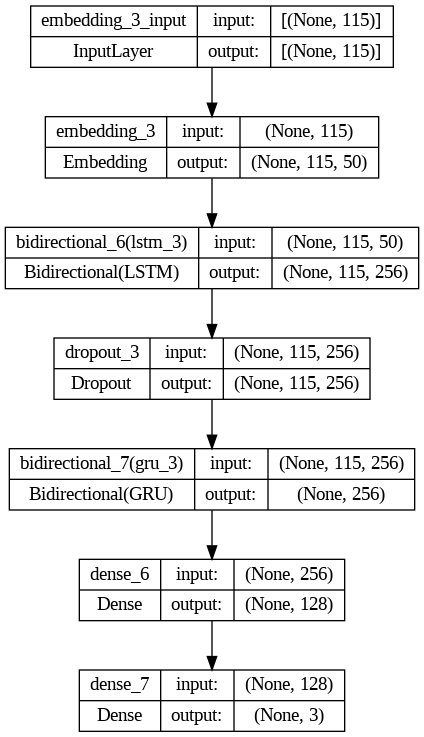

In [42]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
hist = model.fit(X_train, y_train_encoded, epochs=15, validation_split=0.3)

Epoch 1/15
268/268 [==============================] - 228s 810ms/step - loss: 0.9377 - accuracy: 0.5235 - f1_score: 0.4719 - val_loss: 0.8273 - val_accuracy: 0.6056 - val_f1_score: 0.5863
Epoch 2/15
268/268 [==============================] - 212s 792ms/step - loss: 0.7589 - accuracy: 0.6434 - f1_score: 0.6188 - val_loss: 0.8069 - val_accuracy: 0.6124 - val_f1_score: 0.6130
Epoch 3/15
268/268 [==============================] - 233s 870ms/step - loss: 0.6724 - accuracy: 0.7003 - f1_score: 0.6887 - val_loss: 0.7989 - val_accuracy: 0.6306 - val_f1_score: 0.6211
Epoch 4/15
268/268 [==============================] - 233s 871ms/step - loss: 0.6051 - accuracy: 0.7421 - f1_score: 0.7336 - val_loss: 0.8819 - val_accuracy: 0.6053 - val_f1_score: 0.6002
Epoch 5/15
268/268 [==============================] - 232s 868ms/step - loss: 0.5389 - accuracy: 0.7735 - f1_score: 0.7677 - val_loss: 0.9834 - val_accuracy: 0.6096 - val_f1_score: 0.5950
Epoch 6/15
268/268 [==============================] - 233s 8

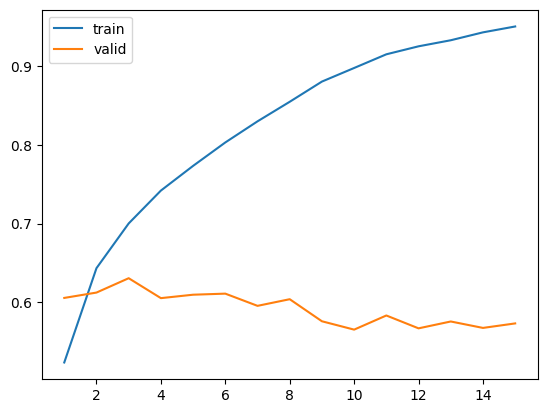

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [46]:
model.evaluate(X_test, y_test_encoded)

96/96 [==============================] - 27s 280ms/step - loss: 1.7273 - accuracy: 0.5819 - f1_score: 0.5756


[1.7273435592651367,
 0.5818895101547241,
 array([0.68835455, 0.41617882, 0.6222852 ], dtype=float32)]

# ENTRENAMIENTO MODELO 2: Embeddings + LSTM
Embeddings Fasttext

In [47]:
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  60.1M      0  0:00:45  0:00:45 --:--:-- 74.1M


In [48]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [49]:
model_fasttext = FasttextEmbeddings()
# Mirar cómo sube el uso de RAM en colab!

In [50]:
# Eliminación de stopwords
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

for word in list(word_index):
  if (word[0] in stop):
    word_index.pop(word)
    print(word)

i
and
it
a
is
in
are
as
it's
i'm
am
at
if
an
all
also
about
around
arms
after
its
i've
any
area
another
almost
actually
absolutely
into
isn't
i'd
always
adorable
arm
above
although
issue
i'll
able
arrived
anything
amazing
across
agree
inches
already
away
again
item
itchy
instead
add
immediately
available
athletic
ivory
ankle
appears
idea
awkward
interesting
armholes
incredibly
inside
adds
addition
imagine
itself
amount
appropriate
issues
awesome
along
anyone
items
anyway
inch
added
average
ago
aren't
airy
awful
appear
attractive
against
afraid
attached
apart
adore
areas
ag
altered
im
attention
initially
alone
ish
instructions
ankles
anywhere
actual
amp
appreciate
adjustable
inseam
interest
inner
aware
accurate
air
impressed
avoid
it'll
alas
adding
armpit
armpits
allows
ironing
appeared
instantly
asked
iron
asymmetrical
accessories
awkwardly
arrive
image
additional
assumed
ideal
adjust
age
impossible
ill
including
alternative
appearance
ahead
advice
intricate
art
incredible
armhole
attr

In [51]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer
nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))



preparing embedding matrix...
number of null word embeddings: 162


In [52]:
# Alumno: Entrene su modelo con LSTM utilizando embeddings pre-entrenados.

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape, weights=[embedding_matrix], trainable=False))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(GRU(128)))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(units=out_shape, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',  tfa.metrics.F1Score(num_classes=3,average=None)])
model2.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 300)          600000    
                                                                 
 bidirectional_8 (Bidirecti  (None, 115, 256)          439296    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 115, 256)          0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 3)                

In [53]:
hist2 = model2.fit(X_train, y_train_encoded, epochs=15, validation_split=0.3)

Epoch 1/15
268/268 [==============================] - 278s 1s/step - loss: 1.0827 - accuracy: 0.4018 - f1_score: 0.3844 - val_loss: 1.2033 - val_accuracy: 0.3443 - val_f1_score: 0.1808
Epoch 2/15
268/268 [==============================] - 299s 1s/step - loss: 1.0649 - accuracy: 0.4229 - f1_score: 0.4126 - val_loss: 1.0533 - val_accuracy: 0.4296 - val_f1_score: 0.3984
Epoch 3/15
268/268 [==============================] - 263s 984ms/step - loss: 1.0408 - accuracy: 0.4508 - f1_score: 0.4303 - val_loss: 1.0451 - val_accuracy: 0.4435 - val_f1_score: 0.4287
Epoch 4/15
268/268 [==============================] - 265s 987ms/step - loss: 1.0184 - accuracy: 0.4749 - f1_score: 0.4576 - val_loss: 1.0295 - val_accuracy: 0.4497 - val_f1_score: 0.4155
Epoch 5/15
268/268 [==============================] - 266s 992ms/step - loss: 1.0014 - accuracy: 0.4922 - f1_score: 0.4682 - val_loss: 1.0209 - val_accuracy: 0.4745 - val_f1_score: 0.4465
Epoch 6/15
268/268 [==============================] - 272s 1s/step

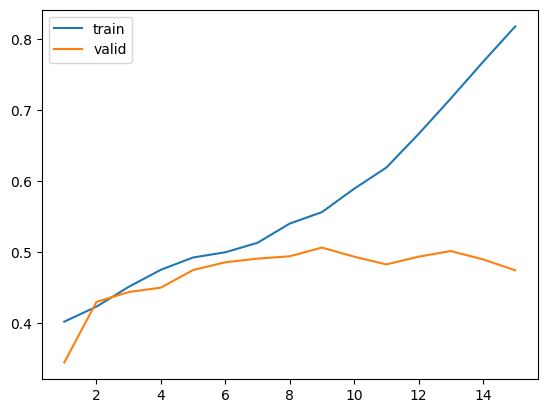

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [55]:
model2.evaluate(X_test, y_test_encoded)

96/96 [==============================] - 28s 291ms/step - loss: 1.5697 - accuracy: 0.4930 - f1_score: 0.4855


[1.5697287321090698,
 0.4929715692996979,
 array([0.5769041 , 0.33516484, 0.5444101 ], dtype=float32)]

## CONCLUSIONES MODELO 1

En resumen, el modelo que no utiliza embeddings ha mostrado una buena performance en el conjunto de entrenamiento, con un F1-score de 0.9501, pero también ha revelado un claro problema de overfitting, evidenciado por el F1-score de 0.5700 en el conjunto de validación.

El resultado en el conjunto de prueba, con un F1-score de 0.5756, muestra que el modelo aún falla al querer generalizar con nuevos datos. Para mejorar la eficiencia, se podría el uso de embeddings, aplicar técnicas de regularización, evaluar distintas arquitecturas y ajustar los hiperparámetros para encontrar un equilibrio entre el rendimiento en entrenamiento y validación, lo que permitirá al modelo ser más efectivo en situaciones del mundo real.

## CONCLUSIONES MODELO 2

En este modelo, se incluyeron embeddings para mejorar su capacidad de comprender el contexto y las relaciones semánticas en los datos de texto pero los resultados no fueron mejores. El F1-score en el conjunto de entrenamiento, con un valor de 0.8159, sigue siendo sólido, lo que indica que el modelo puede aprender bien de los datos de entrenamiento. Sin embargo, el F1-score en el conjunto de validación 0.4682 y en el conjunto de prueba 0.4855 sigue siendo muy bajo, lo que sugiere que el modelo todavía no puede generalizar adecuadamente a nuevos datos y sigue sufriendo de overfitting. La incorporación de embeddings puede no haber sido suficiente para abordar las deficiencias del modelo en términos de generalización, y es necesario seguir investigando y ajustando la arquitectura, los hiperparámetros y las técnicas de regularización para lograr un mejor rendimiento.